In [54]:
import duckdb
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

In [55]:
import warnings
warnings.filterwarnings('ignore')

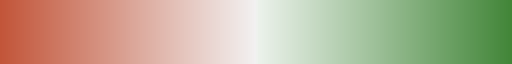

In [56]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 5
hm_h = 3.5
set_title = False
my_cmap = sns.diverging_palette(20, 125, as_cmap=True)
my_cmap

In [57]:
my_palette = sns.diverging_palette(20, 125)
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

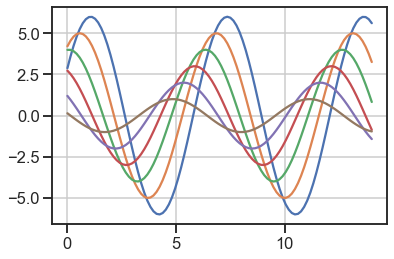

In [58]:
x = np.linspace(0, 14, 100)
for i in range(1, 7):
    plt.plot(x, np.sin(x + i * .5) * (7 - i) * 1)

In [78]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category', 'distribution']

# Functions

In [59]:
def fix_ylim(ax):
    min_y = 1e99
    for col in ax.collections:
        min_y = min(min_y, col.get_offsets()[0][1])
    diff = ax.get_ylim()[0] - min_y
    ax.set_ylim(bottom=diff)

In [97]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [144]:
def compute_relative_runtime(con, baseline, cat_df, col):
    con.register('baseline', baseline)
    con.register('cat_df', cat_df)
    q = f"""
        select cast(log2(b.count) as int) as row_count, b.columns as columns,
               round(b.{col} / c.{col}, 1) as relative_runtime
        from baseline b, cat_df c
        where b.count = c.count
          and b.columns = c.columns
        order by row_count, columns
    """
    con.execute(q)
    return con.fetchdf()

In [62]:
def get_color_norm(dfs, col):
    vmin = 1e99
    vmax = 0
    for df in dfs:
        vmin = min(vmin, min(df[col]))
        vmax = max(vmax, max(df[col]))
    if vmin < 1:
        vmin = 1 / vmin
    else:
        vmin = 1
    factor = max(1 / vmin, vmax) #min(, 4)
    vmin = 1 / factor
    vmax = factor
    return colors.TwoSlopeNorm(1, vmin=vmin, vmax=vmax)

In [63]:
def create_heatmap(df, columns, title, fname, w=hm_w, h=hm_h):
    color_norm = get_color_norm([df], columns[2])
    fig, ax = plt.subplots(figsize=(w, h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=0, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True, cbar=False, norm=color_norm)
    g.invert_yaxis()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(title)
    ax.set_xlabel('rows')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

In [64]:
def multi_heatmap(dfs, titles, columns, fname, w=hm_w, h=hm_h, normalize_colors=False):
    actual_w = w * len(dfs) + 1.5**len(dfs)
    fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(actual_w, h), sharey=True)
    color_norm = get_color_norm(dfs, columns[2]) if normalize_colors else None
    
    for i in range(len(dfs)):
        ax = axes[i]
        sns.heatmap(dfs[i].pivot(columns[0], columns[1], columns[2]), linewidths=0, cbar=False, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True,
                    norm=color_norm)
        ax.invert_yaxis()
        for _, spine in ax.spines.items():
            spine.set_visible(True)
        labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
        ax.set_xlabel('rows')
        ax.set_title(titles[i])
        if i > 0:
            ax.set_ylabel('')
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='y', which='major', length=0)
    plt.subplots_adjust(wspace=0.1)
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

In [104]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter'])
comparator_df.head()

,count,columns,col_width,category,distribution,total,sort,scatter
0,1024,1,4,col,powerlaw,24542.0,24542.0,0.0
1,1024,1,4,col,random,88334.0,88334.0,0.0
2,1024,1,4,col,uniqueN,41625.0,41625.0,0.0
3,1024,1,4,col_branchless,powerlaw,22750.0,22750.0,0.0
4,1024,1,4,col_branchless,random,61208.0,61208.0,0.0


# Sorting Columnar Data

In [114]:
columnar_categories = ['col_branchless', 'col_ss']
distributions = ['random', 'uniqueN', 'powerlaw']

In [147]:
dfs = []
for dist in distributions:
    dist_df = comparator_df[comparator_df['distribution'] == dist]
    baseline_df = dist_df[dist_df['category'] == 'col']
    for cat in columnar_categories:
        cat_df = dist_df[dist_df['category'] == cat]
        assert(len(baseline_df) == len(cat_df))
        dfs.append(compute_relative_runtime(con, baseline_df, cat_df, 'sort'))

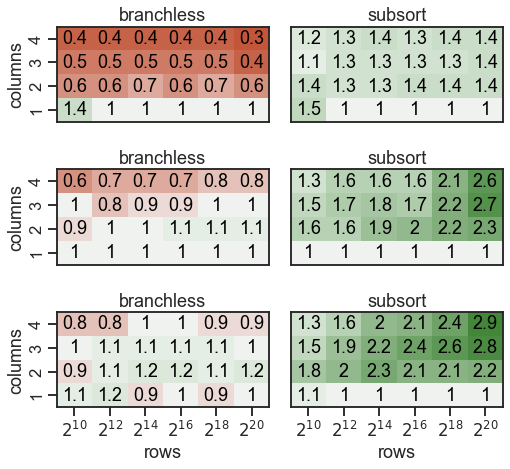

In [189]:
fig, axes = plt.subplots(nrows=len(distributions), ncols=2,
                         sharex=True, sharey=True,
                         figsize=(8,7))
color_norm = get_color_norm(dfs, 'relative_runtime')
for i in range(len(dfs)):
    ax = axes[int(i / 2)][i % 2]
    sns.heatmap(dfs[i].pivot('columns', 'row_count', 'relative_runtime'),
                linewidths=0, cbar=False, cmap=my_cmap, ax=ax,
                annot=True, annot_kws={'c': 'black'}, robust=True,
                norm=color_norm)
    ax.invert_yaxis()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    if i > 3:
        ax.set_xticklabels(labels)
        ax.set_xlabel('rows')
    else:
        ax.set_xticklabels([])
        ax.set_xlabel('')
        ax.tick_params(axis='x', which='major', length=0)
    if i % 2 == 1:
        ax.set_title('subsort')
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='y', which='major', length=0)
    else:
        ax.set_title('branchless')
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.savefig(f'figures/column_comparators.eps', bbox_inches="tight")
plt.show()

# Sorting Row Data

In [186]:
axes[0]

array([<AxesSubplot:title={'center':'subsort'}, ylabel='columns'>,
       <AxesSubplot:title={'center':'branchless'}>], dtype=object)

# Key Normalization

# The `mem*` functions

In [65]:
mem_colors = [my_palette[0], my_palette[5]]

In [66]:
platforms = ['x86_clang', 'arm_clang']

In [89]:
q = []
for platform in platforms:
    q.append(f"select 'memcpy' as function, '{platform}' as platform, * from read_csv_auto('results/memcpy_{platform}.csv')")
    q.append(f"select 'memcmp' as function, '{platform}' as platform, * from read_csv_auto('results/memcmp_{platform}.csv')")
con.execute(' union all '.join(q))
mem_df = con.fetchdf()

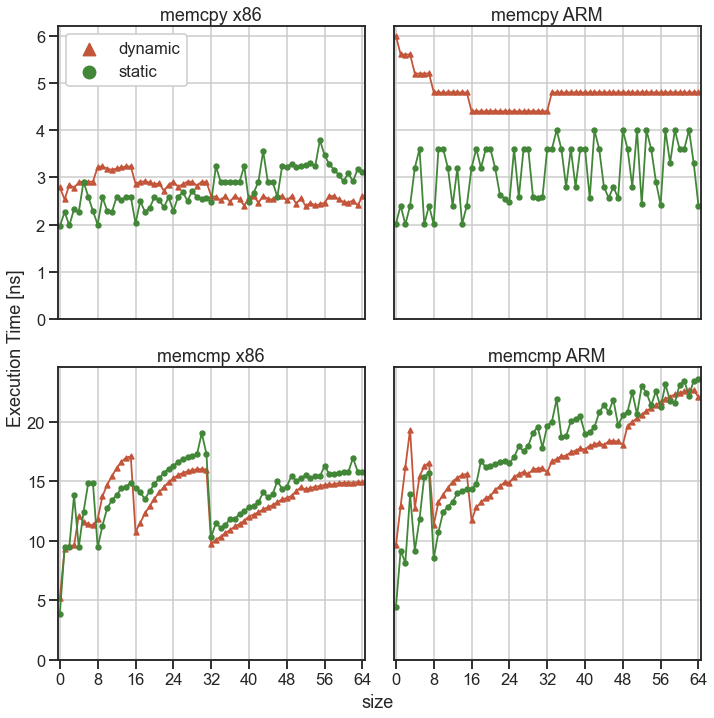

In [90]:
with plt.rc_context({'lines.linewidth': 1}):
    plot = sns.catplot(data=mem_df, kind='point', x='num_bytes', y='time', col='platform', hue='type',
                       sharex='col', sharey="row", row="function", markers=['^', 'o'], palette=mem_colors,
                       facet_kws=dict(despine=False), legend=False)

plot.axes[0][0].set(ylabel=None, xlabel=None, title='memcpy x86')
plot.axes[0][1].set(ylabel=None, xlabel=None, title='memcpy ARM')
plot.axes[1][0].set(ylabel=None, xlabel=None, title='memcmp x86')
plot.axes[1][1].set(ylabel=None, xlabel=None, title='memcmp ARM')

plot.fig.text(0.515, 0, 'size', ha='center')
plot.fig.text(0, 0.5, 'Execution Time [ns]', va='center', rotation='vertical')

for i, arr in enumerate(plot.axes):
    for j, ax in enumerate(arr):
        ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
        ax.set_ylim(ymin=0)
        ax.grid(True)
        for col in ax.collections:
            col.set_sizes([25])
        
        if i == 0:
            ax.tick_params(axis='x', which='major', length=0)
        if j == 1:
            ax.tick_params(axis='y', which='major', length=0)

# plot._legend.set_visible(False)
with plt.rc_context({'legend.markerscale': 2.5}):
    lgnd = plot.axes[0][0].legend(loc='upper left', framealpha=1)

# plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.savefig('figures/mem.eps', bbox_inches='tight')

In [77]:
con.execute("""
select d.time as dynamic_time, s.time as static_time, d.time / s.time as speedup, d.function, d.num_bytes, d.platform
from mem_df d, mem_df s
where d.type = 'dynamic'
and s.type = 'static'
and d.function = s.function
and d.num_bytes = s.num_bytes
and d.platform = s.platform
order by speedup desc
""")
speedup = con.fetchdf()
con.execute("""
select avg(speedup), function, platform from speedup where num_bytes <= 16 group by function, platform
""")
con.fetchdf().head(20)

,avg(speedup),function,platform
0,2.006946,memcpy,arm_clang
1,1.282502,memcmp,arm_clang
2,1.288757,memcpy,x86_clang
3,1.054138,memcmp,x86_clang


# Radix Sort

# Trace

In [310]:
def process_trace_csv_xcode(con, what, ns_per_grp):
    csv_q = ' UNION ALL '.join([f"""
            select *, '{dist}' dist from read_csv_auto('results/xcode_output/trace_{what}_{dist}.csv', sample_size=30000)
        """ for dist in distributions])
    con.execute(f"""
    with csv_cte as ({csv_q}),
    trace as (
        select category, time::DOUBLE as time, dist,
        L1D_CACHE_MISS_LD + L1D_CACHE_MISS_ST as cm,
        BRANCH_MISPRED_NONSPEC as bm
        from csv_cte
    ), norm_trace as (
        select category, dist, cm, bm,
               time - (select min(time)
                       from trace t2
                       where t1.category = t2.category
                       and t1.dist = t2.dist) as time
        from trace t1
    ), div as (
        select category, dist, cm, bm, time / {ns_per_grp} as time
        from norm_trace
    )
    select * from div
    order by category, dist, time
    """)
    div = con.fetchdf()
    
    con.execute(f"""
    with diffs as (
       select category, dist, time, time - lag(time, 1) over
                                  (partition by category, dist order by time)
                                  as diff from div
    )
    select * from diffs order by diff desc nulls last
    """)
    diffs1 = con.fetchdf()
    
    con.execute(f"""
    select category, case when diff < (2000000000 / {ns_per_grp})
                     then (select max(time)
                           from diffs1 c
                           where c.category = d.category)
                     else time end as time, diff, dist
    from diffs1 d
    """)
    diffs2 = con.fetchdf()
    
    bounds = pd.DataFrame()
    for cat in diffs2['category'].unique():
        for dist in diffs2['dist'].unique():
            con.execute(f"""select * from diffs2
                            where category = '{cat}'
                            and dist = '{dist}'
                            order by diff desc nulls last
                            limit 2""")
            bounds = pd.concat([bounds, con.fetchdf()])
    
    con.execute(f"""
    select category, time, sum(cm) over (partition by category, dist order by time) as cm,
                           sum(bm) over (partition by category, dist order by time) as bm,
           dist
    from div c
    where time > (select min(b.time)
                  from bounds b
                  where c.category = b.category
                  and c.dist = b.dist)
      and time < (select max(b.time)
                  from bounds b
                  where c.category = b.category
                  and c.dist = b.dist)
    """)
    cutoff = con.fetchdf()
    
    con.execute(f"""
    with norm_again as (
        select category, dist,
               time - (select min(time)
                       from cutoff c2
                       where c1.category = c2.category
                       and c1.dist = c2.dist) as time,
               cm, bm
        from cutoff c1
    )
    select category, dist, time::DOUBLE * {ns_per_grp} / 1000000000 as time, cm, bm
    from norm_again
    order by category, dist, time
    """)
    
    result = con.fetchdf()
    print(len(result))
    return result

In [311]:
trace_df = process_trace_csv_xcode(con, 'comparator', 100000000)

307399


In [316]:
con.execute(f"""
select category, dist,
       round(sum(cm) / 1e12,2) cm,
       round(sum(bm) / 1e12,2) bm,
       max(time) - min(time) as time
from trace_df
group by category, dist
order by category, dist
""")
con.fetchdf()

,category,dist,cm,bm,time
0,col_all,powerlaw,10.88,1.02,2.886396
1,col_all,random,2.93,0.23,1.511399
2,col_all,uniqueN,12.72,1.49,3.322399
3,col_branchless,powerlaw,10.62,0.24,3.371900
4,col_branchless,random,15.84,0.77,4.267000
5,col_branchless,uniqueN,14.60,0.61,4.007499
6,col_ss,powerlaw,1.89,0.08,1.074000
7,col_ss,random,1.53,0.19,1.159503
8,col_ss,uniqueN,2.91,0.14,1.397499
9,row_all,powerlaw,0.22,0.19,0.616099


In [49]:
def plot_trace(df, counter, fig_name, categories=None, h=5, asp=1, the_ax=None, lg=False, yl=True, title=None):
    if categories:
        if len(categories) == 2:
            palette = [my_palette[0], my_palette[5]]
            markers = ['^', 'o']
        else:
            markers = ['d' if 'Col' in cat else 's' for cat in categories]
            palette = [trace_palette_map.get(cat.replace('Col', '').replace('Row', ''), my_palette[0]) for cat in categories]
    else:
        markers = ['d']*20
        palette = sns.color_palette()
    with plt.rc_context({'lines.linewidth': 1}):
        if not the_ax:
            plot = sns.catplot(kind='point', data=df, x='time', y='counter', hue='category',
                               markers=markers, facet_kws=dict(despine=False),
                               palette=palette, legend=False, h=h, aspect=asp)
            ax = plot.axes[0][0]
        else:
            ax = sns.pointplot(data=df, x='time', y='counter', hue='category',
                               markers=markers, facet_kws=dict(despine=False),
                               palette=palette, ax=the_ax, legend=False)
        ax.legend([], [], frameon=False)
    
    if max(df['counter']) / 1e9 > 1:
        q = '× 1e9'
        y_divisor = 1e9
    elif max(df['counter']) / 1e6 > 1:
        q = '× 1e6'
        y_divisor = 1e6
    elif max(df['counter']) / 1e3 > 1:
        q = '× 1e3'
        y_divisor = 1e3

    if counter == 'cm':
        ylabel = f'Cache misses {q}'
    else:
        ylabel = f'Branch mispredictions {q}'
    
    if yl:
        ax.set(ylabel=ylabel, xlabel='Execution time [s]')
    else:
        ax.set(ylabel='', xlabel='Execution time [s]')
        ax.set_ylabel('')
#         plt.setp(ax.get_yticklabels(), visible=False)
        plt.subplots_adjust(wspace=0)

    ax.set_title(title)
    fix_ylim(ax)
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
#     ax.set_xticklabels([f'{float(label) / 1e9}' for label in xlabels])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
#     ax.tick_params(axis='y', which='major', length=0)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: float(x / y_divisor)))

    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([25])

    if lg:
        with plt.rc_context({'legend.markerscale': 2}):
            lgnd = ax.legend(fontsize='small', framealpha=1)
        if categories:
            for new, old in zip(categories, lgnd.get_texts()):
                old.set_text(new)
    return ax

In [50]:
def multi_trace(dfs, fig_name, categories, counters, h=5, asp=1, lg=0, titles=[None, None]):
    shy = counters[0] == counters[1]
    plot, axes = plt.subplots(nrows=1, ncols=2, figsize=(2 * h * asp, h), sharey=shy)
    for i in range(2):
        legend_on = lg == i
        if i == 1 and counters[0] == counters[1]:
            yl = False
        else:
            yl = True
        plot_trace(dfs[i], counters[i], '', categories=categories, h=h, asp=asp, the_ax=axes[i],
                   lg=legend_on, yl=yl, title=titles[i])
    plt.tight_layout()
    plt.savefig(f'figures/{fig_name}.eps', bbox_inches='tight')
    plt.show()

## Sorting Columnar Data

In [208]:
trace_df = process_trace_csv_xcode(con, 'comparator', 100000000)

RuntimeError: Parser Error: parser error : syntax error at or near "time"
LINE 16:                time - (select min(time) from trace t2 where t1.category = t2.category) as time
        from trace t1
    ), div as (
        select category, dist, cm, bm, time / 100000000 as time
        from norm_trace
    )
    select * from div
    order by category, dist, time
    ...
                        ^

## Sorting Row Data

In [51]:
agg_ns = 100000000
cm_comparator_df = process_trace_csv_xcode(con, 'results/xcode_output/trace_comparator.csv', 'cm', agg_ns)
bm_comparator_df = process_trace_csv_xcode(con, 'results/xcode_output/trace_comparator.csv', 'bm', agg_ns)

rows: 123
max time: 3900000000
rows: 123
max time: 3900000000


In [52]:
comp_cats = ['ColBranch',
            'ColBranchless',
            'ColSubSort',
            'RowBranch',
            'RowBranchless',
            'RowSubSort',
            'NormalizedKey']

In [53]:
con.execute(f"""
with joined as (
    select cm.category, cm.time, cm.counter as cache_misses, bm.counter as branch_mispredictions
    from cm_comparator_df cm, bm_comparator_df bm
    where cm.category = bm.category
    and cm.time = bm.time
)
select
    category,
    max(time) as time_s,
    sum(cache_misses) / 1000000000 as cache_misses_billions,
    sum(branch_mispredictions) / 1000000000 as branch_mispredictions_billions
from joined
group by category
""")
res = con.fetchall()
print('\\toprule')
print('Approach & ExecutionTime [s] & CM × 1e9 & BM × 1e9 \\\\')
print('\\midrule')
for i, row in enumerate(res):
    print(f'\\textit{{{comp_cats[i]}}} & ' + ' & '.join([f'{v:.2f}' for v in row[1:]]) + ' \\\\')
print('\\bottomrule')

\toprule
Approach & ExecutionTime [s] & CM × 1e9 & BM × 1e9 \\
\midrule
\textit{ColBranch} & 3400000000.00 & 13.90 & 3.26 \\
\textit{ColBranchless} & 3900000000.00 & 14.89 & 1.24 \\
\textit{ColSubSort} & 1400000000.00 & 3.30 & 0.35 \\
\textit{RowBranch} & 800000000.00 & 0.38 & 0.93 \\
\textit{RowBranchless} & 900000000.00 & 0.41 & 0.28 \\
\textit{RowSubSort} & 400000000.00 & 0.35 & 0.16 \\
\textit{NormalizedKey} & 800000000.00 & 0.35 & 0.68 \\
\bottomrule


## Sort

In [679]:
agg_ns = 40000000
cm_sort_df = process_trace_csv_perf(con, 'results/perf_output/trace_sort.csv', 'cm', agg_ns)
bm_sort_df = process_trace_csv_perf(con, 'results/perf_output/trace_sort.csv', 'bm', agg_ns)

     category   time  diff
0       radix   60.0  50.0
1       radix  125.0  50.0
0  pdq_static   60.0  50.0
1  pdq_static  137.0  50.0
42
     category   time  diff
0       radix   60.0  50.0
1       radix  125.0  50.0
0  pdq_static   60.0  50.0
1  pdq_static  137.0  50.0
42


In [607]:
# plot_trace(cm_sort_df, 'cm', 'cm_sort', lg=True)

In [608]:
# plot_trace(bm_sort_df, 'bm', 'bm_sort', lg=True)

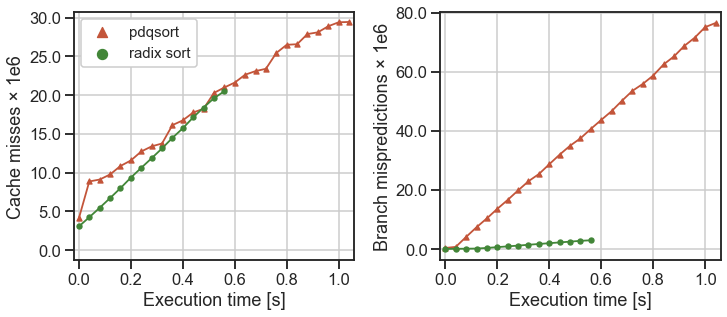

In [680]:
multi_trace([cm_sort_df, bm_sort_df],
            'trace_sort', ['pdqsort', 'radix sort'], ['cm', 'bm'], h=4.75, asp=1.1, lg=0)

## Key Merge

In [858]:
agg_ns = 2100000
cm_merge_key_df = process_trace_csv_perf(con, 'results/perf_output/trace_merge_key.csv', 'cm', agg_ns)
bm_merge_key_df = process_trace_csv_perf(con, 'results/perf_output/trace_merge_key.csv', 'bm', agg_ns)

             category  time    diff
0  row_all_branchless  2474  1017.0
1  row_all_branchless  3448   966.0
0             row_all  2454  1004.0
1             row_all  3418   964.0
0            row_norm  2427   976.0
1            row_norm  2494   113.0
0      col_branchless  6326   964.0
1      col_branchless  7394   959.0
0          col_branch  6306   963.0
1          col_branch  7320   962.0
74
             category  time    diff
0  row_all_branchless  2474  1017.0
1  row_all_branchless  3448   966.0
0             row_all  2454  1004.0
1             row_all  3418   964.0
0            row_norm  2427   976.0
1            row_norm  2494   113.0
0      col_branchless  6326   964.0
1      col_branchless  7394   959.0
0          col_branch  6306   963.0
1          col_branch  7320   962.0
74


In [859]:
cm_merge_key_df['category'].unique()

array(['col_branch', 'col_branchless', 'row_all_branchless', 'row_norm'],
      dtype=object)

In [860]:
comp_cats = ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey']

In [861]:
con.execute("""
with joined as (
    select cm.category, cm.time, cm.counter as cache_misses, bm.counter as branch_mispredictions
    from cm_merge_key_df cm, bm_merge_key_df bm
    where cm.category = bm.category
    and cm.time = bm.time
)
select
    category,
    max(time)::DOUBLE as time_s,
    sum(cache_misses) / 1000000 as cache_misses_billions,
    sum(branch_mispredictions) / 1000000 as branch_mispredictions_billions
from joined
group by category
""")
res = con.fetchall()
print('\\toprule')
print('Approach & Time [s] & CM × 1e6 & BM × 1e6 \\\\')
print('\\midrule')
for i, row in enumerate(res):
    print(f'\\textit{{{comp_cats[i]}}} & ' + ' & '.join([f'{v:.2f}' for v in row[1:]]) + ' \\\\')
print('\\bottomrule')

\toprule
Approach & Time [s] & CM × 1e6 & BM × 1e6 \\
\midrule
\textit{ColBranch} & 0.10 & 25.13 & 0.24 \\
\textit{ColBranchless} & 0.22 & 28.13 & 0.26 \\
\textit{RowBranch} & 0.01 & 0.52 & 0.00 \\
\textit{RowBranchless} & 0.13 & 133.74 & 71.04 \\
\bottomrule


In [829]:
# plot_trace(cm_merge_key_df, 'cm', 'cm_merge_key', h=4.5, asp=1.2, lg=True)

In [830]:
# plot_trace(bm_merge_key_df, 'bm', 'bm_merge_key', h=4.5, asp=1.2, lg=True)

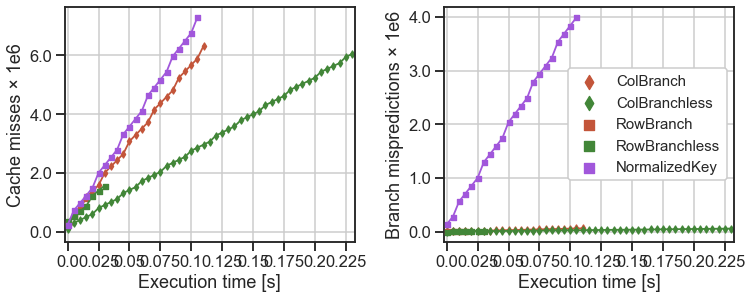

In [833]:
multi_trace([cm_merge_key_df, bm_merge_key_df],
            'trace_merge_key', ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey'],
            ['cm', 'bm'], h=4.5, asp=1.2, lg=1)

## Payload Merge

In [751]:
agg_ns = 50000000
cm_merge_payload_df = process_trace_csv_perf(con, 'results/perf_output/trace_merge_payload.csv', 'cm', agg_ns)
bm_merge_payload_df = process_trace_csv_perf(con, 'results/perf_output/trace_merge_payload.csv', 'bm', agg_ns)

  category   time  diff
0      row   44.0  40.0
1      row  101.0  40.0
0      col   43.0  40.0
1      col  105.0  40.0
39
  category   time  diff
0      row   44.0  40.0
1      row  101.0  40.0
0      col   43.0  40.0
1      col  105.0  40.0
39


In [752]:
# plot_trace(cm_merge_payload_df, 'cm', 'cm_merge_payload', lg=True)

In [753]:
# plot_trace(bm_merge_payload_df, 'bm', 'bm_merge_payload')

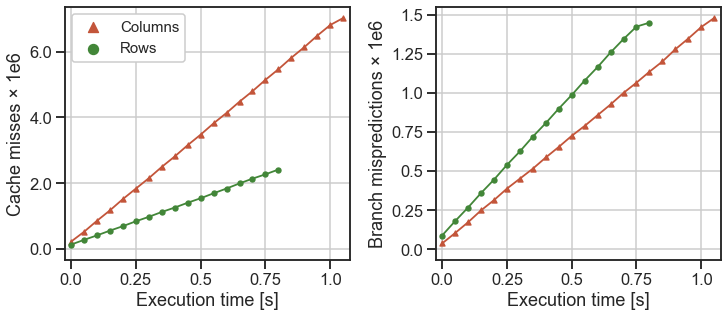

In [754]:
multi_trace([cm_merge_payload_df, bm_merge_payload_df],
            'trace_merge_payload', ['Columns', 'Rows'],
            ['cm', 'bm'], h=4.75, asp=1.1, lg=0)

# Templating ...

In [ ]:
# for i in range(1, 257):
#     print(f'\tcase {i}:')
#     print(f'\t\treturn memcmp_fixed<{i}>(str1, str2);')

In [ ]:
# for i in range(1, 257):
#     print(f'\tcase {i}:')
#     print(f'\t\treturn MemcpyFixed<{i}>(dest, src);')

In [ ]:
# row = 'BranchedRowOrderEntry'
# row = 'BranchlessRowOrderEntry'
# row = 'NormalizedRowOrderEntry'
# print('switch (columns){')
# for i in range(1, 8):
#     print(f'case {i}:')
#     print(f'return MergeKeyRows<{row}{i}<T>>(left, right, count);')
# print('default:')
# print('assert(false);')
# print('}')